In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from geopy.geocoders import Nominatim
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import os
import joblib
import pickle
import mlflow.sklearn

In [2]:
from sklearn.ensemble import RandomForestRegressor

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [4]:
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
df = pd.read_csv(r"C:\Users\axa\THE BRIDGE_23\SEMANA 25. DESAFIO TRIPULACIONES\df.csv", sep=",")

# Limpieza del dataset. Tratamiento de Valores nulos

In [6]:
df = df[~df['distrito'].isin(['Ciudalcampo', 'La Moraleja'])]

In [7]:
# Eliminar 18 Columnas
columns_to_drop = ['Unnamed: 0', 'origin_id', 'construction_year', 'first_appearance', 'last_appearance', 'is_exact_address','is_vertical','n_floor', 'has_storage', 'has_garage_included', 'has_common_zones', 'has_terrace', 'has_air_conditioner', 'cardinal_direction_id','has_racket_zone','has_security','direccion','distrito']
df1 = df.drop(columns=columns_to_drop)

In [8]:
def imputar_n_rooms(row):
    if pd.notna(row['n_rooms']):
        return row['n_rooms']
    elif pd.notna(row['description']):
        description = row['description'].lower()
        if 'estudio' in description or 'loft' in description or 'sin divisiones' in description:
            return 0
    return None

df1['n_rooms'] = df1.apply(imputar_n_rooms, axis=1)

In [9]:
df1['n_rooms'].fillna(1, inplace=True)

In [10]:
valores_a_eliminar = [9.0, 10.0, 15.0, 22.0]
df1 = df1[~df1['n_rooms'].isin(valores_a_eliminar)]

In [11]:
df1['n_baths'].fillna(1, inplace=True)

In [12]:
reemplazos = {0.0: 2.0, 20.0: 2.0, 22.0: 2.0, 55.0: 1.0}
df1['n_baths'].replace(reemplazos, inplace=True)

In [13]:
valores_a_eliminar = [10.0, 11.0, 13.0]
df1 = df1[~df1['n_baths'].isin(valores_a_eliminar)]

In [14]:
keywords = ['garaje', 'garage', 'plaza de parking', 'parking']
condition = df1['description'].str.contains('|'.join(keywords), case=False)
df1['has_garage'] = condition.apply(lambda x: 't' if x else 'f')

In [15]:
df1.loc[df1['tipology'] == 'chalet', 'has_garage'] = 't'

In [16]:
keywords = ['piscina', 'tiene piscina', 'dispone de piscina']
condition = df1['description'].str.contains('|'.join(keywords), case=False)
df1['has_pool'] = np.where(condition, 't', 'f')

In [17]:
condition = (df1['has_elevator'].isnull()) & (df1['description'].str.contains('con ascensor|tiene ascensor', case=False, na=False))
df1.loc[condition, 'has_elevator'] = 't'
condition = (df1['has_elevator'].isnull())
df1.loc[condition, 'has_elevator'] = 'f'

In [18]:
condition = (df1['is_exterior'].isnull()) & (df1['description'].str.contains('exterior|con terraza', case=False, na=False))
df1.loc[condition, 'is_exterior'] = 't'
condition = (df1['is_exterior'].isnull())
df1.loc[condition, 'is_exterior'] = 'f'

In [19]:
df1 = df1.drop(["description", "title", "url"], axis=1)

In [20]:
df1

,area,local_price,replace,replace.1,tipology,n_rooms,n_baths,has_garage,has_pool,has_elevator,is_exterior
0,135,3200,40.437687,-3.691055,Piso,1.0,2.0,f,f,t,t
1,250,6000,40.439434,-3.686233,Piso,4.0,4.0,t,t,t,t
2,146,2460,40.468037,-3.708661,Piso,3.0,2.0,t,t,t,t
3,98,3000,40.441212,-3.670406,Piso,3.0,3.0,f,f,f,t
4,125,3675,40.411247,-3.668222,Piso,3.0,2.0,t,t,t,t
...,...,...,...,...,...,...,...,...,...,...,...
6357,45,1450,40.414158,-3.701161,Piso,2.0,1.0,f,f,f,f
6358,30,1250,40.425045,-3.705386,Piso,2.0,1.0,f,f,f,f
6359,73,900,40.392933,-3.736926,Piso,3.0,1.0,t,t,t,t
6360,32,850,40.417221,-3.703297,Piso,0.0,1.0,f,f,t,t


In [21]:
import os
carpeta_mis_documentos = r"C:\Users\axa\THE BRIDGE_23\SEMANA 25. DESAFIO TRIPULACIONES"
if not os.path.exists(carpeta_mis_documentos):
    os.makedirs(carpeta_mis_documentos)
ruta_guardado = os.path.join(carpeta_mis_documentos, "dflimpio.csv")
df1.to_csv(ruta_guardado, index=False)
print(f"El archivo CSV se ha guardado en: {ruta_guardado}")

El archivo CSV se ha guardado en: C:\Users\axa\THE BRIDGE_23\SEMANA 25. DESAFIO TRIPULACIONES\dflimpio.csv


# Transformaciones

In [22]:
le = LabelEncoder()
df1['tipology'] = le.fit_transform(df1['tipology'])

In [23]:
le = LabelEncoder()
df1['has_garage'] = le.fit_transform(df1['has_garage'])

In [24]:
le = LabelEncoder()
df1['has_pool'] = le.fit_transform(df1['has_pool'])

In [25]:
le = LabelEncoder()
df1['has_elevator'] = le.fit_transform(df1['has_elevator'])

In [26]:
le = LabelEncoder()
df1['is_exterior'] = le.fit_transform(df1['is_exterior'])

# EDA

In [27]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6350 entries, 0 to 6361
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area          6350 non-null   int64  
 1   local_price   6350 non-null   int64  
 2   replace       6350 non-null   float64
 3   replace.1     6350 non-null   float64
 4   tipology      6350 non-null   int32  
 5   n_rooms       6350 non-null   float64
 6   n_baths       6350 non-null   float64
 7   has_garage    6350 non-null   int32  
 8   has_pool      6350 non-null   int32  
 9   has_elevator  6350 non-null   int32  
 10  is_exterior   6350 non-null   int32  
dtypes: float64(4), int32(5), int64(2)
memory usage: 471.3 KB


In [28]:
df1.describe()

,area,local_price,replace,replace.1,tipology,n_rooms,n_baths,has_garage,has_pool,has_elevator,is_exterior
count,6350.000000,6350.000000,6350.000000,6350.000000,6350.000000,6350.000000,6350.000000,6350.000000,6350.000000,6350.000000,6350.000000
mean,111.399528,2332.666299,40.431616,-3.686906,0.975433,2.191969,1.789291,0.324094,0.236220,0.807244,0.841260
std,135.176823,1793.438036,0.029411,0.033466,0.154813,1.220203,1.043703,0.468072,0.424793,0.394494,0.365462
min,17.000000,0.000000,40.332451,-3.832705,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,1200.000000,40.414421,-3.704299,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
50%,85.000000,1800.000000,40.429138,-3.691864,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000
75%,130.000000,2871.750000,40.450226,-3.674411,1.000000,3.000000,2.000000,1.000000,0.000000,1.000000,1.000000
max,7840.000000,20000.000000,40.616005,-3.528354,1.000000,8.000000,9.000000,1.000000,1.000000,1.000000,1.000000


# Variable: "area"

In [29]:
unique_values = df1['area'].unique()
unique_values = sorted(unique_values)
unique_values_count = df1['area'].nunique()
area_counts = df1['area'].value_counts()

print("Valores únicos:", unique_values)
print("Cantidad de valores únicos en la columna 'area':", unique_values_count)
print(area_counts)

Valores únicos: [17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 213, 214, 215, 217, 218, 219, 220, 221, 222, 223, 224, 225, 227, 228, 229, 230, 231, 232, 233, 

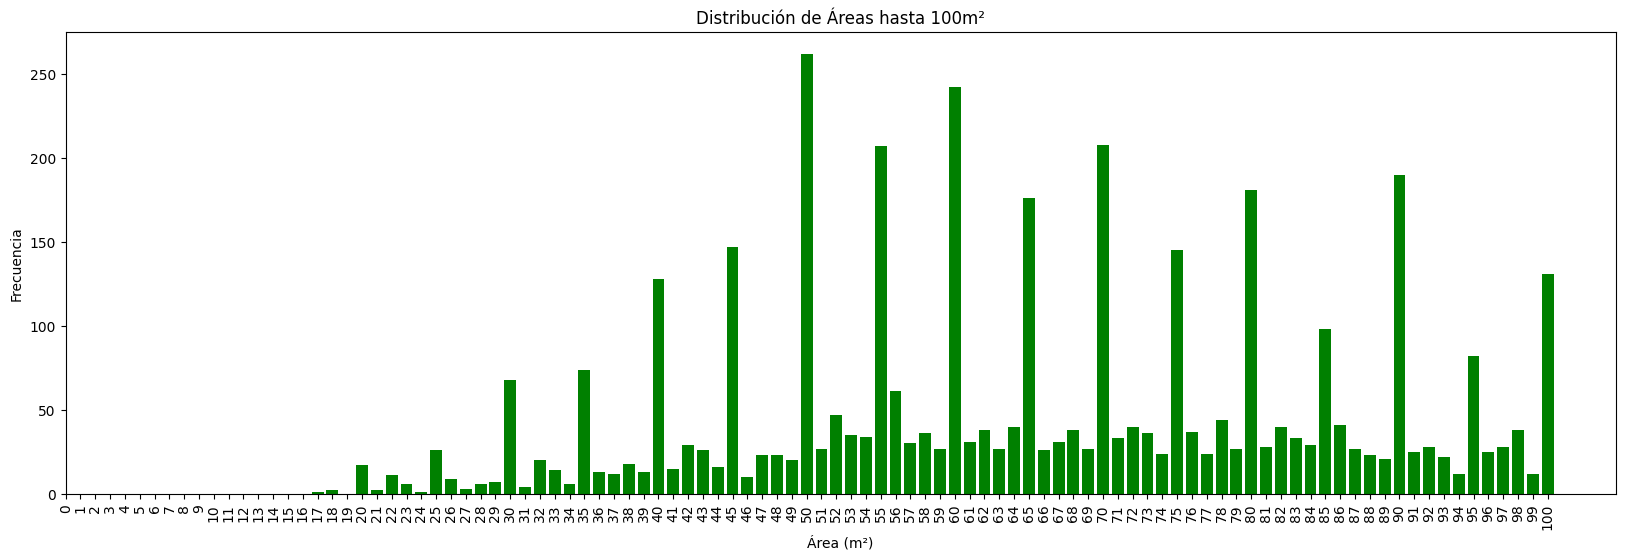

In [30]:
df_areas_hasta_100 = df1[df1['area'] <= 100]
frecuencia_areas = df_areas_hasta_100['area'].value_counts().sort_index()
plt.figure(figsize=(20, 6))
plt.bar(frecuencia_areas.index, frecuencia_areas.values, color='green')
plt.xlabel('Área (m²)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Áreas hasta 100m²')
plt.xticks(range(101), rotation=90)
plt.show()

# Variable: "local_price"

In [31]:
unique_values = df1['local_price'].unique()
unique_values = sorted(unique_values)
unique_values_count = df1['local_price'].nunique()
local_price_counts = df1['local_price'].value_counts()

print("Valores únicos:", unique_values)
print("Cantidad de valores únicos en la columna 'local_price':", unique_values_count)
print(local_price_counts)

Valores únicos: [0, 400, 490, 499, 500, 530, 549, 550, 575, 580, 590, 595, 600, 608, 620, 625, 630, 645, 649, 650, 665, 670, 675, 680, 690, 695, 699, 700, 710, 720, 725, 730, 740, 749, 750, 752, 760, 761, 764, 765, 768, 770, 775, 780, 785, 790, 795, 799, 800, 805, 810, 811, 820, 825, 829, 830, 840, 845, 849, 850, 853, 855, 860, 870, 874, 875, 877, 880, 883, 890, 895, 899, 900, 904, 906, 910, 915, 917, 920, 925, 930, 935, 937, 940, 941, 945, 947, 950, 955, 960, 966, 970, 975, 980, 982, 984, 985, 990, 995, 999, 1000, 1004, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1060, 1065, 1066, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1107, 1108, 1110, 1120, 1122, 1125, 1130, 1134, 1135, 1145, 1149, 1150, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1194, 1195, 1199, 1200, 1210, 1220, 1221, 1225, 1230, 1235, 1240, 1245, 1249, 1250, 1252, 1260, 1261, 1265, 1270, 1275, 1280, 1285, 1289, 1290, 1295, 1299, 1300, 1310, 1320, 1325, 1329, 1347, 1350, 1351, 1357, 1360, 1365, 1370, 1375, 1377,

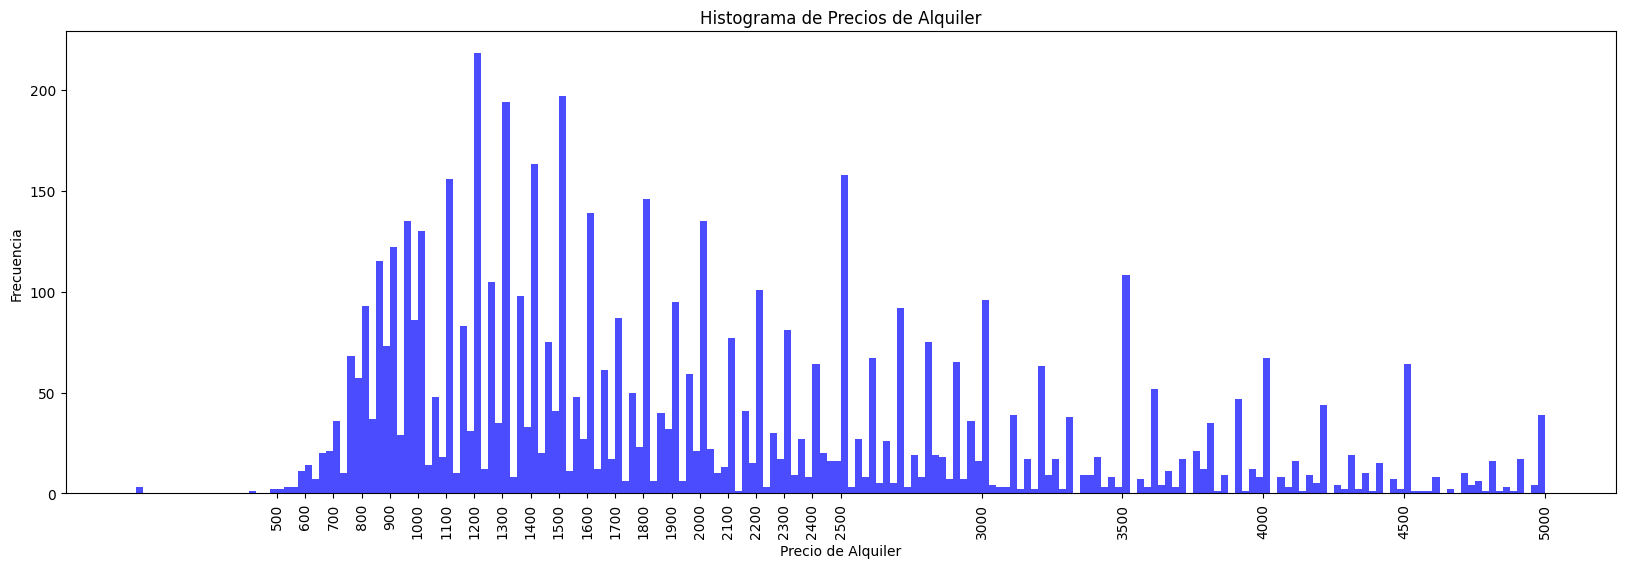

In [32]:
import matplotlib.pyplot as plt
local_prices_filtered = df1[df1['local_price'] <= 5000]['local_price']
plt.figure(figsize=(20, 6))
plt.hist(local_prices_filtered, bins=200, color='blue', alpha=0.7)
x_ticks = [500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 3000, 3500, 4000, 4500, 5000]
x_labels = [str(x) for x in x_ticks]
plt.xticks(x_ticks, x_labels, rotation=90)
plt.xlabel('Precio de Alquiler')
plt.ylabel('Frecuencia')
plt.title('Histograma de Precios de Alquiler')
plt.show()

# Variable: "tipology"... (chalet / piso)

In [33]:
unique_values = df1['tipology'].unique()
unique_values = sorted(unique_values)
unique_values_count = df1['tipology'].nunique()
tipology_counts = df1['tipology'].value_counts()

print("Valores únicos:", unique_values)
print("Cantidad de valores únicos en la columna 'tipology':", unique_values_count)
print(tipology_counts)

Valores únicos: [0, 1]
Cantidad de valores únicos en la columna 'tipology': 2
tipology
1    6194
0     156
Name: count, dtype: int64


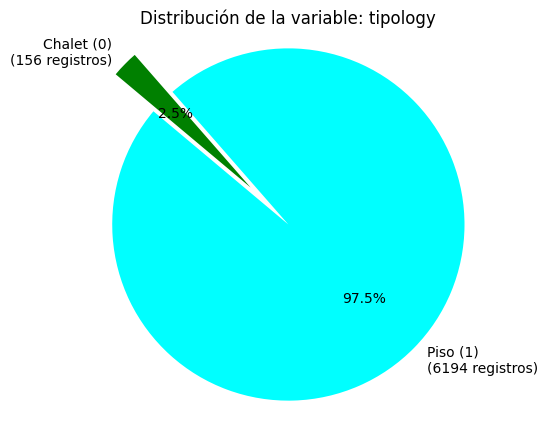

In [34]:
count_tipology = df1['tipology'].value_counts()
labels = ['Piso (1)', 'Chalet (0)']
colors = ['cyan', 'green']
count_records = [6194, 156]
explode = (0, 0.3)
plt.figure(figsize=(5, 5))
_, texts, _ = plt.pie(count_tipology, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode=explode)
for i, text in enumerate(texts):
    text.set_text(f"{labels[i]}\n({count_records[i]} registros)")
plt.title('Distribución de la variable: tipology')
plt.axis('equal')
plt.show()

# Variable: "n_rooms"

In [35]:
unique_values = df1['n_rooms'].unique()
unique_values = sorted(unique_values)
unique_values_count = df1['n_rooms'].nunique()
n_rooms_counts = df1['n_rooms'].value_counts()

print("Valores únicos:", unique_values)
print("Cantidad de valores únicos en la columna 'n_rooms':", unique_values_count)
print(n_rooms_counts)

Valores únicos: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
Cantidad de valores únicos en la columna 'n_rooms': 9
n_rooms
2.0    2078
1.0    1731
3.0    1434
4.0     584
0.0     265
5.0     184
6.0      52
7.0      14
8.0       8
Name: count, dtype: int64


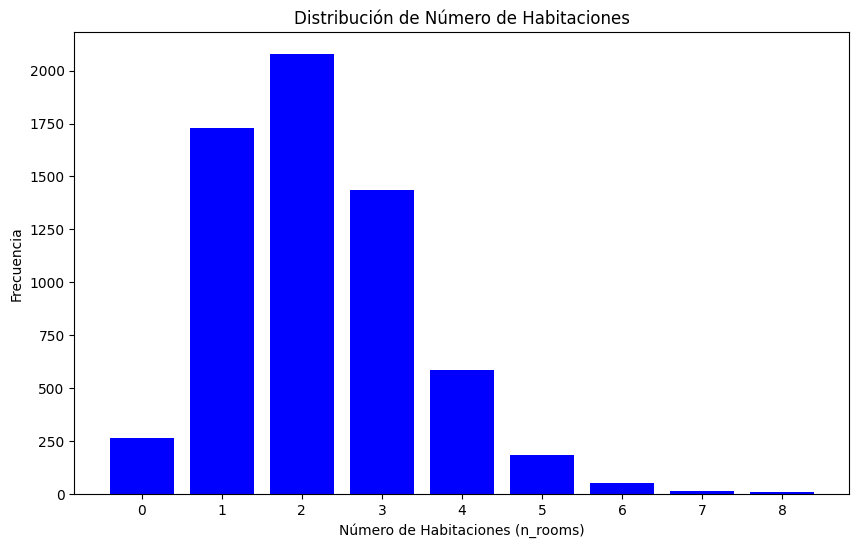

In [36]:
valores_x = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
frecuencia_n_rooms = df1['n_rooms'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.bar(frecuencia_n_rooms.index, frecuencia_n_rooms.values, color='blue')
plt.xlabel('Número de Habitaciones (n_rooms)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Número de Habitaciones')
plt.xticks(valores_x)
plt.show()

# Variable: "n_baths"

In [37]:
unique_values = df1['n_baths'].unique()
unique_values = sorted(unique_values)
unique_values_count = df1['n_baths'].nunique()
n_baths_counts = df1['n_baths'].value_counts()

print("Valores únicos:", unique_values)
print("Cantidad de valores únicos en la columna 'n_baths':", unique_values_count)
print(n_baths_counts)

Valores únicos: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
Cantidad de valores únicos en la columna 'n_baths': 9
n_baths
1.0    3162
2.0    2088
3.0     635
4.0     283
5.0     134
6.0      32
7.0       7
8.0       5
9.0       4
Name: count, dtype: int64


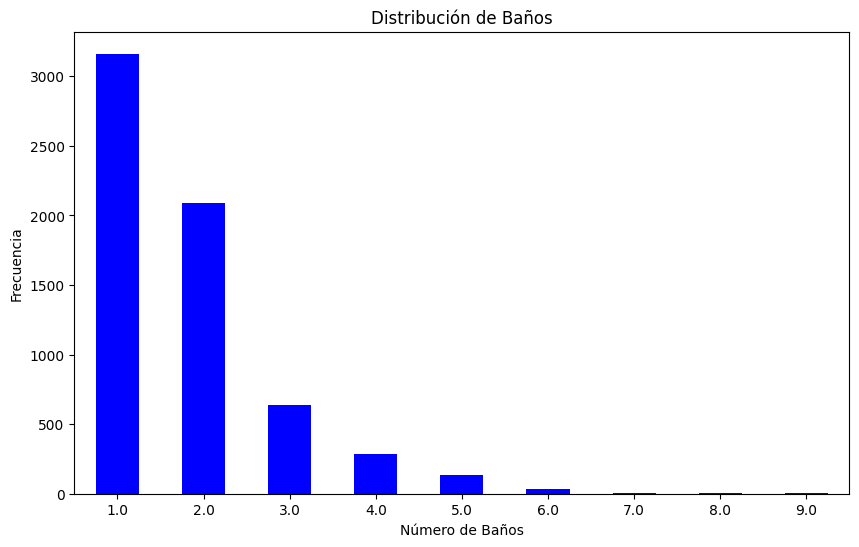

In [38]:
data = df1['n_baths'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
data.plot(kind='bar', color='blue')
plt.title('Distribución de Baños')
plt.xlabel('Número de Baños')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.show()

# Variable: "has_garage"

In [39]:
unique_values = df1['has_garage'].unique()
unique_values = sorted(unique_values)
unique_values_count = df1['has_garage'].nunique()
has_garage_counts = df1['has_garage'].value_counts()

print("Valores únicos:", unique_values)
print("Cantidad de valores únicos en la columna 'has_garage':", unique_values_count)
print(has_garage_counts)

Valores únicos: [0, 1]
Cantidad de valores únicos en la columna 'has_garage': 2
has_garage
0    4292
1    2058
Name: count, dtype: int64


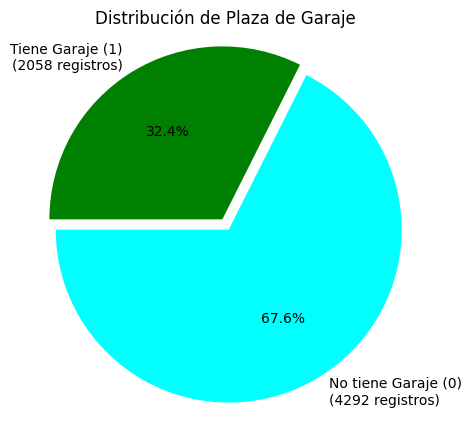

In [40]:
count_tipology = df1['has_garage'].value_counts()
labels = ['No tiene Garaje (0)', 'Tiene Garaje (1)']
colors = ['cyan', 'green']
count_records = [4292, 2058]
explode = (0, 0.07)
plt.figure(figsize=(5, 5))
_, texts, _ = plt.pie(count_tipology, labels=labels, colors=colors, autopct='%1.1f%%', startangle=180, explode=explode)
for i, text in enumerate(texts):
    text.set_text(f"{labels[i]}\n({count_records[i]} registros)")
plt.title('Distribución de Plaza de Garaje')
plt.axis('equal')
plt.show()

# Variable: "has_pool"

In [41]:
unique_values = df1['has_pool'].unique()
unique_values = sorted(unique_values)
unique_values_count = df1['has_pool'].nunique()
has_pool_counts = df1['has_pool'].value_counts()

print("Valores únicos:", unique_values)
print("Cantidad de valores únicos en la columna 'has_pool':", unique_values_count)
print(has_pool_counts)

Valores únicos: [0, 1]
Cantidad de valores únicos en la columna 'has_pool': 2
has_pool
0    4850
1    1500
Name: count, dtype: int64


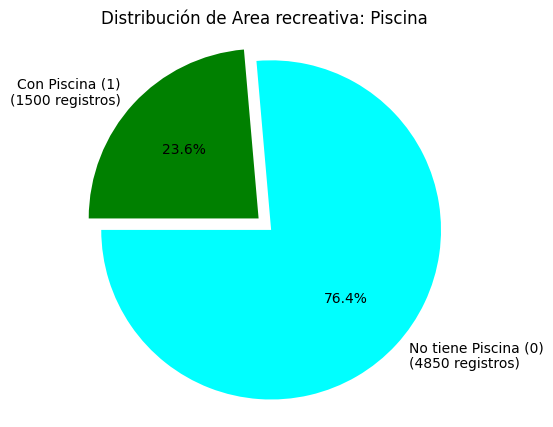

In [42]:
count_tipology = df1['has_pool'].value_counts()
labels = ['No tiene Piscina (0)', 'Con Piscina (1)']
colors = ['cyan', 'green']
count_records = [4850, 1500]
explode = (0, 0.1)
plt.figure(figsize=(5, 5))
_, texts, _ = plt.pie(count_tipology, labels=labels, colors=colors, autopct='%1.1f%%', startangle=180, explode=explode)
for i, text in enumerate(texts):
    text.set_text(f"{labels[i]}\n({count_records[i]} registros)")
plt.title('Distribución de Area recreativa: Piscina')
plt.axis('equal')
plt.show()

# Variable: "has_elevator"

In [43]:
unique_values = df1['has_elevator'].unique()
unique_values = sorted(unique_values)
unique_values_count = df1['has_elevator'].nunique()
has_elevator_counts = df1['has_elevator'].value_counts()

print("Valores únicos:", unique_values)
print("Cantidad de valores únicos en la columna 'has_elevator':", unique_values_count)
print(has_elevator_counts)

Valores únicos: [0, 1]
Cantidad de valores únicos en la columna 'has_elevator': 2
has_elevator
1    5126
0    1224
Name: count, dtype: int64


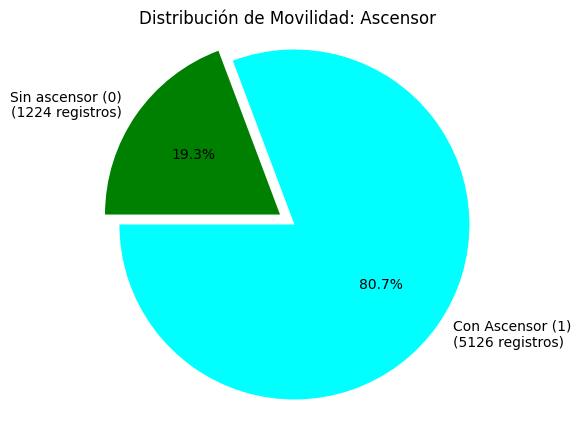

In [44]:
count_tipology = df1['has_elevator'].value_counts()
labels = ['Con Ascensor (1)', 'Sin ascensor (0)']
colors = ['cyan', 'green']
count_records = [5126, 1224]
explode = (0, 0.1)
plt.figure(figsize=(5, 5))
_, texts, _ = plt.pie(count_tipology, labels=labels, colors=colors, autopct='%1.1f%%', startangle=180, explode=explode)
for i, text in enumerate(texts):
    text.set_text(f"{labels[i]}\n({count_records[i]} registros)")
plt.title('Distribución de Movilidad: Ascensor')
plt.axis('equal')
plt.show()

# Variable: "is_exterior"

In [45]:
unique_values = df1['is_exterior'].unique()
unique_values = sorted(unique_values)
unique_values_count = df1['is_exterior'].nunique()
is_exterior_counts = df1['is_exterior'].value_counts()

print("Valores únicos:", unique_values)
print("Cantidad de valores únicos en la columna 'is_exterior':", unique_values_count)
print(is_exterior_counts)

Valores únicos: [0, 1]
Cantidad de valores únicos en la columna 'is_exterior': 2
is_exterior
1    5342
0    1008
Name: count, dtype: int64


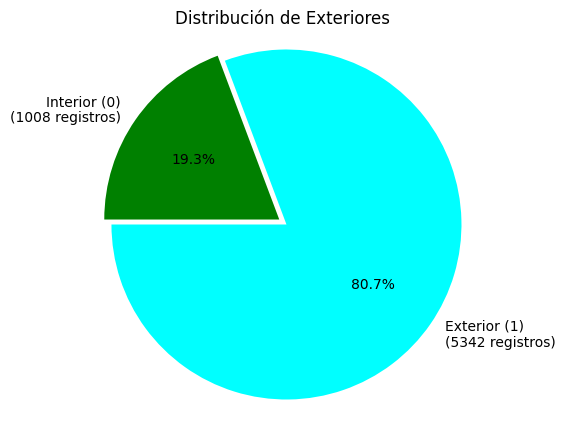

In [46]:
count_tipology = df1['has_elevator'].value_counts()
labels = ['Exterior (1)', 'Interior (0)']
colors = ['cyan', 'green']
count_records = [5342, 1008]
explode = (0, 0.05)
plt.figure(figsize=(5, 5))
_, texts, _ = plt.pie(count_tipology, labels=labels, colors=colors, autopct='%1.1f%%', startangle=180, explode=explode)
for i, text in enumerate(texts):
    text.set_text(f"{labels[i]}\n({count_records[i]} registros)")
plt.title('Distribución de Exteriores')
plt.axis('equal')
plt.show()

In [47]:
matriz_correlacion = df1.corr()
matriz_correlacion

,area,local_price,replace,replace.1,tipology,n_rooms,n_baths,has_garage,has_pool,has_elevator,is_exterior
area,1.000000,0.511649,0.192218,-0.007856,-0.386212,0.495339,0.554684,0.177500,0.132601,-0.009472,0.031033
local_price,0.511649,1.000000,0.130366,-0.068256,-0.271081,0.552636,0.731870,0.103941,0.022081,0.101598,0.053049
replace,0.192218,0.130366,1.000000,0.075662,-0.165093,0.164453,0.214617,0.194784,0.215815,0.072263,0.068576
replace.1,-0.007856,-0.068256,0.075662,1.000000,0.016346,0.007193,0.000016,0.187894,0.226013,0.109516,0.062606
tipology,-0.386212,-0.271081,-0.165093,0.016346,1.000000,-0.346065,-0.405385,-0.124852,-0.148850,0.314454,0.217798
n_rooms,0.495339,0.552636,0.164453,0.007193,-0.346065,1.000000,0.751932,0.250657,0.115484,0.042200,0.094482
n_baths,0.554684,0.731870,0.214617,0.000016,-0.405385,0.751932,1.000000,0.297465,0.167703,0.084577,0.079532
has_garage,0.177500,0.103941,0.194784,0.187894,-0.124852,0.250657,0.297465,1.000000,0.528248,0.162657,0.077055
has_pool,0.132601,0.022081,0.215815,0.226013,-0.148850,0.115484,0.167703,0.528248,1.000000,0.106333,0.041709
has_elevator,-0.009472,0.101598,0.072263,0.109516,0.314454,0.042200,0.084577,0.162657,0.106333,1.000000,0.300105


<Axes: >

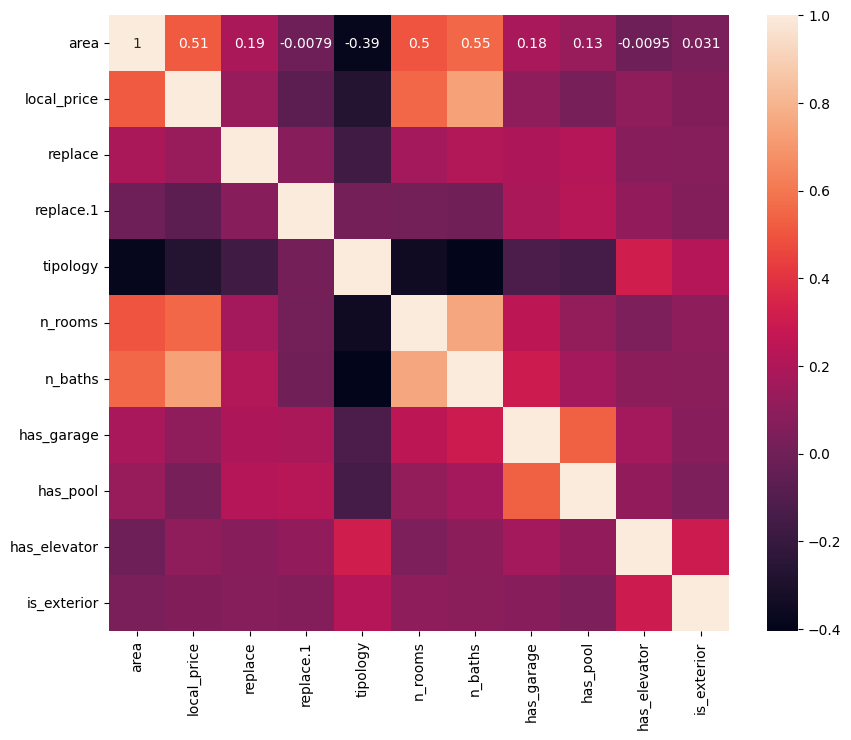

In [48]:
plt.figure(figsize=(10,8))
sns.heatmap(matriz_correlacion,annot=True)

# Estandarización (5 variables)

In [49]:
scaler = StandardScaler()
columns_to_scale = ['area', 'replace', 'replace.1', 'n_rooms', 'n_baths']
df1[columns_to_scale] = scaler.fit_transform(df1[columns_to_scale])

In [50]:
import os
carpeta_mis_documentos = r"C:\Users\axa\THE BRIDGE_23\SEMANA 25. DESAFIO TRIPULACIONES"
if not os.path.exists(carpeta_mis_documentos):
    os.makedirs(carpeta_mis_documentos)
ruta_guardado = os.path.join(carpeta_mis_documentos, "Valoración_Alquileres.csv")
df1.to_csv(ruta_guardado, index=False)
print(f"El archivo CSV se ha guardado en: {ruta_guardado}")

El archivo CSV se ha guardado en: C:\Users\axa\THE BRIDGE_23\SEMANA 25. DESAFIO TRIPULACIONES\Valoración_Alquileres.csv


# ML (Modelos Predictivos de Regresión)

In [51]:
X = df1.drop('local_price', axis=1)  
y = df1['local_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True)

In [52]:
modeloRFR = RandomForestRegressor(n_estimators=100, random_state=1)
modeloRFR.fit(X_train, y_train)

RandomForestRegressor(random_state=1)

In [53]:
y_pred = modeloRFR.predict(X_test)

In [54]:
mse = mean_squared_error(y_test, y_pred)
print(f'Error Cuadrático Medio (MSE): {mse}')

Error Cuadrático Medio (MSE): 667873.3613148552


In [55]:
r2 = r2_score(y_test, y_pred)
print(f'Coeficiente de Determinación (R^2): {r2}')

Coeficiente de Determinación (R^2): 0.7783912080597688


In [56]:
importances = modeloRFR.feature_importances_
feature_names = df1.columns.drop("local_price")
print(feature_names)
print(importances)


Index(['area', 'replace', 'replace.1', 'tipology', 'n_rooms', 'n_baths',
       'has_garage', 'has_pool', 'has_elevator', 'is_exterior'],
      dtype='object')
[0.61612972 0.16080113 0.09917913 0.00111578 0.02237443 0.07521702
 0.00676057 0.00889768 0.00474776 0.00477678]


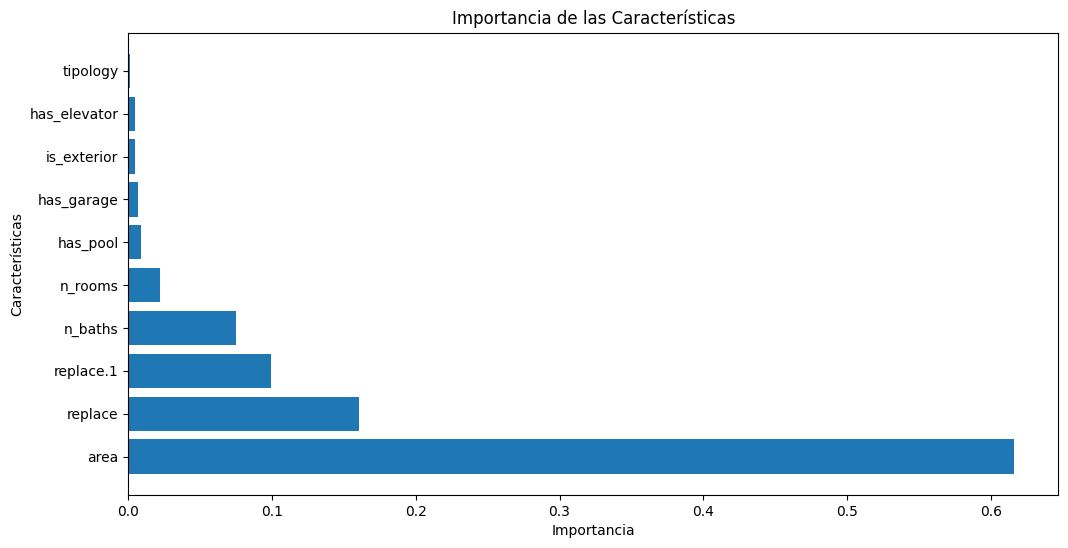

In [57]:
importances = modeloRFR.feature_importances_
feature_names = df1.columns.drop("local_price")
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las Características')
plt.show()